In [25]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import os
import time
import PIL
from torchinfo import summary

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset

In [26]:
data_dir = 'dogs-vs-cats'

train_set_dir = os.path.join(data_dir, 'train')
valid_set_dir = os.path.join(data_dir, 'valid')
test_set_dir = os.path.join(data_dir, 'test')

In [27]:
print(f'the number of train set : {len(os.listdir(train_set_dir))}')
print(f'the number of validation set : {len(os.listdir(valid_set_dir))}')
print(f'the number of test set : {len(os.listdir(test_set_dir))}')

the number of train set : 20000
the number of validation set : 2500
the number of test set : 2500


In [28]:
# torch.utils.data.Dataset을 사용하여 custom dataset 만들기
# 참고: https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html

# 레이블을 지정하는 경우 자주 사용하게 될 듯
class CustomDataset(Dataset):
    '''
    __init__(self, files, root, mode='train', transform=None) : 클래스를 생성할 때 실행되는 생성자
        ㄴfiles : 이미지 파일 이름을 저장하고 있는 list
        ㄴroot : 이미지 파일이 존재하는 폴더 경로
        ㄴmode : 해당 dataset이 학습용인지 평가용인지 체크
        ㄴtransform : 이미지의 전처리를 위한 torchvision.transform
    '''    
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform = transform
        
        # 이미지 파일의 이름에 'cat'이 포함되어 있을 경우
        if 'cat' in files[0]:
            # 고양이 이미지 레이블 - 0
            self.label = 0
        else:
            # 강아지 이미지 레이블 - 1
            self.label = 1
            
    '''
    __len__(self) : Dataset의 길이를 반환하기 위한 메소드
    '''              
    def __len__(self):
        return len(self.files)
    
    '''
    __getitem__(self, index) : 클래스의 인덱스에 접근할 때 자동으로 호출되는 메소드
                               주어진 key에 해당하는 data를 반환하며,
                               key에 해당하는 이미지 파일을 읽고, 전처리 과정을 통해서 data를 리턴합니다. 
                               mode='train'일 경우에는 label을 반환하고, 'train'용이 아닌 경우에는 label을 모르기 때문에 
                               실제 이미지 파일의 경로를 반환하도록 합니다.
    '''        
    def __getitem__(self, index):
        # 이미지 불러오기(경로, 인덱스)
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        # 이미지 전처리
        if self.transform:
            img = self.transform(img)
        # 학습 이미지 리턴 (이미지, 레이블)
        if self.mode == 'train':
            return img, np.array([self.label])
        # 테스트 이미지 리턴
        else:
            return img, self.files[index]        

In [29]:
train_transform = transforms.Compose([transforms.RandomResizedCrop((224, 224)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor()])

In [30]:
dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]

train_dog_dataset = CustomDataset(dog_files[:10000], train_set_dir, transform=train_transform)
train_cat_dataset = CustomDataset(cat_files[:10000], train_set_dir, transform=train_transform)

valid_dog_dataset = CustomDataset(dog_files[10000:11250], valid_set_dir, transform=test_transform)
valid_cat_dataset = CustomDataset(cat_files[10000:11250], valid_set_dir, transform=test_transform)

test_dog_dataset = CustomDataset(dog_files[11250:12500], test_set_dir, transform=test_transform)
test_cat_dataset = CustomDataset(cat_files[11250:12500], test_set_dir, transform=test_transform)

train_dataset = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_dog_dataset, test_cat_dataset])

In [32]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

----------------------------------------------------------------------------------------------------------------------------------------

## SE-Net

![1](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbdNB90%2FbtrifndN5aK%2F4aH24P6bKecBs7R6VN1XBK%2Fimg.png)
![2](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FpZvP2%2FbtqBEAqMq44%2FfQLZXp6PKydP0k1AoSfLG0%2Fimg.png)
![3](https://miro.medium.com/v2/resize:fit:2000/1*x3qCQ7Ep_eKSJC6TSmhebA.png)

In [13]:
class SEBlock(nn.Module):
    # 파라미터가 너무 많이 늘어나는 것을 막기 위해 reduction ratio, r = 16으로 설정
    def __init__(self, in_channels, r = 16):
        super().__init__()
        
        self.squeeze = nn.AdaptiveAvgPool2d((1, 1))
        self.excitation = nn.Sequential(nn.Linear(in_channels, in_channels // r),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(in_channels // r, in_channels),
                                       nn.Sigmoid())
        
    def forward(self, x):
        # input 2x3x224x224
        SE = self.squeeze(x) # 2x3x1x1
        SE = SE.reshape(x.shape[0], x.shape[1]) # 2x3
        SE = self.excitation(SE) # 2x3 -> Linear    
        SE = SE.unsqueeze(dim=2).unsqueeze(dim=3) # 2x3x1x1
        x = x * SE
        return x
    
class SE_Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, inner_channels, stride=1, downsample=None):
        super().__init__()
        
        self.residual = nn.Sequential(nn.Conv2d(in_channels, inner_channels, 1, bias=False),
                                     nn.BatchNorm2d(inner_channels),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(inner_channels, inner_channels, 3, stride=stride, padding=1, bias=False),
                                     nn.BatchNorm2d(inner_channels),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(inner_channels, inner_channels * self.expansion, 1, bias=False),
                                     nn.BatchNorm2d(inner_channels * self.expansion))
        
        self.seblock = SEBlock(inner_channels * self.expansion)
        
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        residual = self.residual(x)
        residual = self.seblock(residual)
        
        if self.downsample is not None:
            shortcut = self.downsample(x)
        else:
            shortcut = x
            
        out = self.relu(residual + shortcut)
        return out
    
class SE_ResNet(nn.Module):
    def __init__(self, block, num_block_list, num_classes = 1000, zero_init_residual = True):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True) # 좀더 메모리 효율적
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layers(block, 64, num_block_list[0], stride=1)
        self.layer2 = self.make_layers(block, 128, num_block_list[1], stride=2)
        self.layer3 = self.make_layers(block, 256, num_block_list[2], stride=2)
        self.layer4 = self.make_layers(block, 512, num_block_list[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, block):
                    nn.init.constant_(m.residual[-1].weight, 0)

    def make_layers(self, block, inner_channels, num_blocks, stride = 1):
        
        if stride != 1 or self.in_channels != inner_channels * block.expansion: 
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, inner_channels * block.expansion, 1, stride=stride, bias=False),
                nn.BatchNorm2d(inner_channels * block.expansion))
        else:
            downsample = None

        layers = []
        layers += [block(self.in_channels, inner_channels, stride, downsample)] # downsample은 첫 block에서만
        self.in_channels = inner_channels * block.expansion
        for _ in range(1, num_blocks):
            layers += [block(self.in_channels, inner_channels)]
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [14]:
def se_resnet50(**kwargs):
    return SE_ResNet(SE_Bottleneck, [3, 4, 6, 3], **kwargs)

def se_resnet101(**kwargs):
    return SE_ResNet(SE_Bottleneck, [3, 4, 23, 3], **kwargs)

def se_resnet152(**kwargs):
    return SE_ResNet(SE_Bottleneck, [3, 8, 36, 3], **kwargs)

In [15]:
model = se_resnet50()

from torchinfo import summary
summary(model, input_size=(2, 3, 224, 224), device='cpu')

Layer (type:depth-idx)                        Output Shape              Param #
SE_ResNet                                     [2, 1000]                 --
├─Conv2d: 1-1                                 [2, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                            [2, 64, 112, 112]         128
├─ReLU: 1-3                                   [2, 64, 112, 112]         --
├─MaxPool2d: 1-4                              [2, 64, 56, 56]           --
├─Sequential: 1-5                             [2, 256, 56, 56]          --
│    └─SE_Bottleneck: 2-1                     [2, 256, 56, 56]          --
│    │    └─Sequential: 3-1                   [2, 256, 56, 56]          58,112
│    │    └─SEBlock: 3-2                      [2, 256, 56, 56]          8,464
│    │    └─Sequential: 3-3                   [2, 256, 56, 56]          16,896
│    │    └─ReLU: 3-4                         [2, 256, 56, 56]          --
│    └─SE_Bottleneck: 2-2                     [2, 256, 56, 56]          --
│    

In [16]:
x = torch.randn(2, 3, 224, 224)
print(model(x).shape)

torch.Size([2, 1000])


----------------------------------------------------------------------------------------------------------------------------------------

## Using pretrained model: SENet

In [19]:
import torch.hub
model_se_resnet50 = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet50',
    pretrained=True,)

Using cache found in C:\Users\57187/.cache\torch\hub\moskomule_senet.pytorch_master


In [20]:
model_se_resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): SEBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Se

In [21]:
fc_layer = model_se_resnet50.fc.in_features
fc_layer

2048

In [34]:
model_se_resnet50.fc = nn.Sequential(nn.Linear(fc_layer, 1024),
                                            nn.ReLU(),
                                            nn.Linear(1024, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 1),
                                            nn.Sigmoid()
                                            )

In [35]:
model_se_resnet50.to(device)
summary(model_se_resnet50, input_size=(2, 3, 224, 224), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [2, 1]                    --
├─Conv2d: 1-1                                 [2, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                            [2, 64, 112, 112]         128
├─ReLU: 1-3                                   [2, 64, 112, 112]         --
├─MaxPool2d: 1-4                              [2, 64, 56, 56]           --
├─Sequential: 1-5                             [2, 256, 56, 56]          --
│    └─SEBottleneck: 2-1                      [2, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                       [2, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2                  [2, 64, 56, 56]           128
│    │    └─ReLU: 3-3                         [2, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                       [2, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5                  [2, 64, 56, 56]           128
│    │ 

In [36]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()
        
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
        
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.legend()
    plt.title('loss')
    plt.show()
    
    plt.plot(train_accuracies, label='train accuracy')
    plt.plot(valid_accuracies, label='valid accuracy')
    plt.legend()
    plt.title('accuracy')
    plt.show()

In [37]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_se_resnet50.parameters(), lr=1e-5)

135.515sec : [Epoch 1/10] -> train loss: 0.3807, train acc: 91.000% / valid loss: 0.0518, valid acc: 98.680%
129.636sec : [Epoch 2/10] -> train loss: 0.0769, train acc: 97.010% / valid loss: 0.0282, valid acc: 99.040%
131.953sec : [Epoch 3/10] -> train loss: 0.0659, train acc: 97.240% / valid loss: 0.0276, valid acc: 99.040%
130.089sec : [Epoch 4/10] -> train loss: 0.0575, train acc: 97.645% / valid loss: 0.0235, valid acc: 99.160%
128.998sec : [Epoch 5/10] -> train loss: 0.0550, train acc: 97.740% / valid loss: 0.0233, valid acc: 99.120%
131.410sec : [Epoch 6/10] -> train loss: 0.0487, train acc: 98.245% / valid loss: 0.0266, valid acc: 99.080%
130.833sec : [Epoch 7/10] -> train loss: 0.0452, train acc: 98.140% / valid loss: 0.0271, valid acc: 99.000%
130.970sec : [Epoch 8/10] -> train loss: 0.0448, train acc: 98.170% / valid loss: 0.0270, valid acc: 99.040%
133.950sec : [Epoch 9/10] -> train loss: 0.0427, train acc: 98.205% / valid loss: 0.0263, valid acc: 99.160%
129.799sec : [Epoch

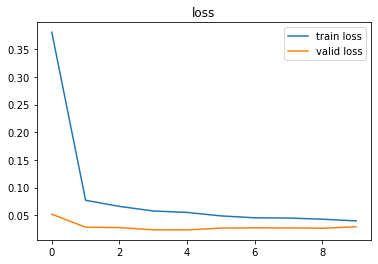

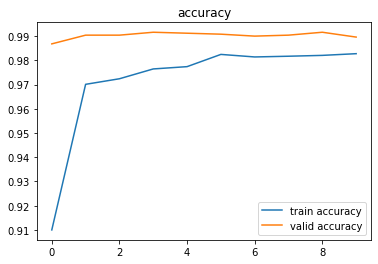

In [38]:
fit(model_se_resnet50, criterion, optimizer, 10, train_loader, valid_loader)

In [39]:
def eval(model, criterion, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        losses = 0
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            
            losses += loss.item()
            correct += y_pred.eq(test_y.cpu()).int().sum()
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')

In [40]:
eval(model_se_resnet50, criterion, test_loader)

eval loss: 0.0252, eval acc: 99.240%


In [41]:
test_dir = 'dogs-vs-cats/test1'
submit_files = [f'{i}.jpg' for i in range(1, 12500+1)]
submit_dataset = CustomDataset(submit_files, test_dir, mode='test', transform=test_transform)
submit_loader = torch.utils.data.DataLoader(submit_dataset, batch_size=128, shuffle=False)

In [42]:
def predict(model, data_loader):
    with torch.no_grad():
        model.eval()
        ret = None
        for img, files in data_loader:
            img = img.to(device)
            pred = model(img)
            
            if ret is None:
                ret = pred.cpu().numpy()
            else:
                ret = np.vstack([ret, pred.cpu().numpy()])
    return ret
   
pred = predict(model_se_resnet50, submit_loader)

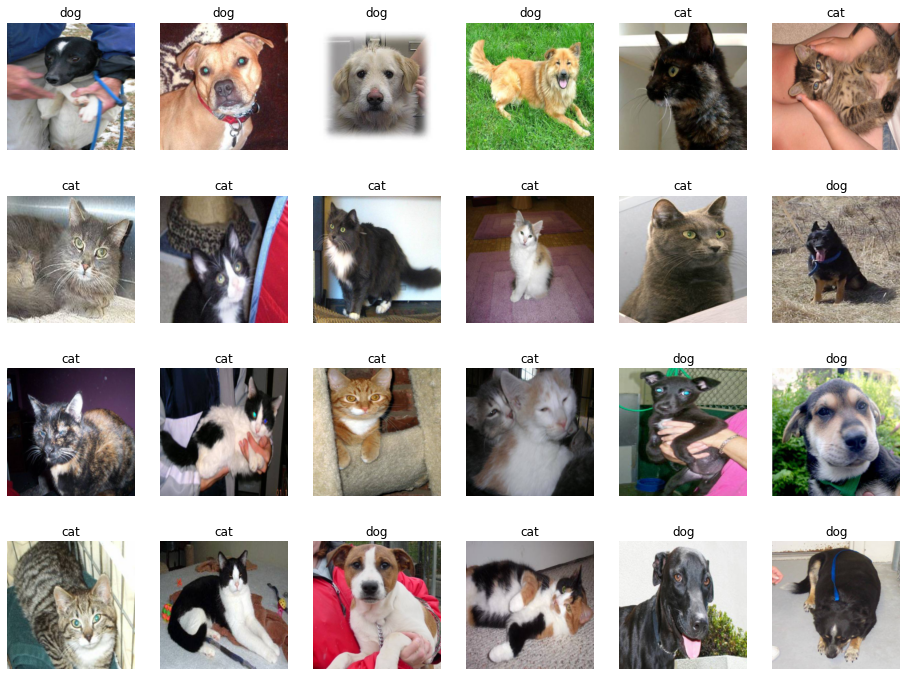

In [43]:
sample_pred = pred[:24]
sample_pred[sample_pred >= 0.5] = 1
sample_pred[sample_pred < 0.5] = 0
 
imgs, files = next(iter(submit_loader))
classes = {0: 'cat', 1: 'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[sample_pred[i][0]])
    a.axis('off')
    a.imshow(np.transpose(imgs[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)